In [72]:
#Importing necessary libraries
import tensorflow as tf
import pandas as pd
import geopandas as gpd
import datetime
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_absolute_error
import pysal
from pysal.explore import esda
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [73]:
#Importing the data
df_nsi = pd.read_csv('nsi_data.csv')
df_occ = pd.read_csv('county_hospitality_occupancy_level.csv')
gdf = gpd.read_file('county_geometry.geojson')

# Occupancy score analysis

In [ ]:
#Data Exploration
df_occ.isna().value_counts()
df_occ.describe()
df_occ.date.value_counts()
df_occ.county.value_counts()

In [75]:
#Computing average values for repeated dates and excluding Sondrio
df_occ['occupancy_level'] = df_occ.groupby(['date','county']).occupancy_level.transform('mean')
df_occ = df_occ.drop_duplicates(subset=['date','county'])
df_occ = df_occ[df_occ.county!='sondrio']

In [76]:
#Computing aggregated values
df_occ['date'] = pd.to_datetime('2022-' + df_occ['date'], format='%Y-%m-%d')
df_occ = df_occ.sort_values(by='date', ascending=True)
df_occ['month'] = df_occ['date'].dt.month
df_occ['occupancy_monthly_mean'] = df_occ.groupby(['county','month']).occupancy_level.transform('mean')
df_occ['occupancy_yearly_mean'] = df_occ.groupby('county').occupancy_level.transform('mean')
df_occ['daily_national_occupancy'] = df_occ.groupby('date').occupancy_level.transform('mean')
df_occ_month = df_occ.drop_duplicates(subset=['county','month'])

No handles with labels found to put in legend.


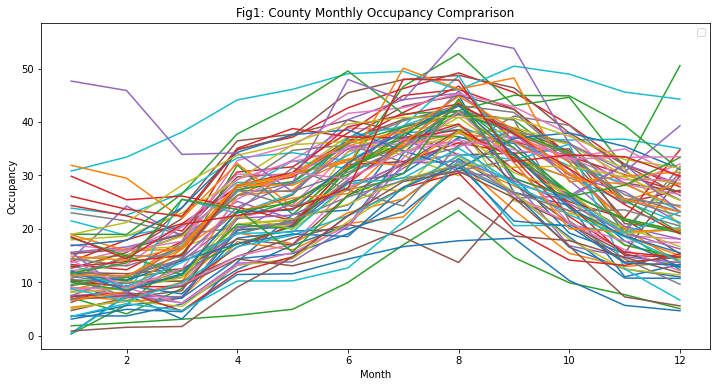

In [77]:
df_occ_month= df_occ_month.sort_values(by='month', ascending=True)
plt.figure(figsize=(12, 6))
for c in df_occ_month.county.unique().tolist():
    plt.plot(df_occ_month[df_occ_month.county==c].month, df_occ_month[df_occ_month.county==c].occupancy_monthly_mean)
plt.xlabel('Month')
plt.ylabel('Occupancy')
plt.title('Fig1: County Monthly Occupancy Comprarison')
plt.legend()
plt.show()

No handles with labels found to put in legend.


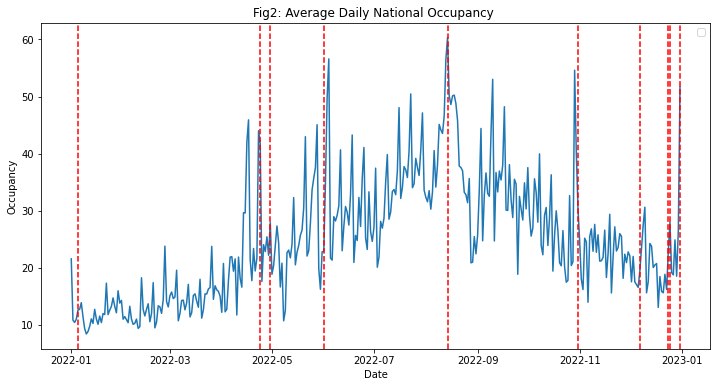

In [78]:
before_holidays = ['2022-01-05','2022-04-24','2022-04-30','2022-06-01','2022-08-14','2022-10-31',
                     '2022-12-07','2022-12-24','2022-12-25','2022-12-31']
plt.figure(figsize=(12, 6))
plt.plot(df_occ.drop_duplicates(subset='date').date, df_occ.drop_duplicates(subset='date').daily_national_occupancy)
plt.xlabel('Date')
plt.ylabel('Occupancy')
plt.title('Fig2: Average Daily National Occupancy ')
for date in before_holidays:
    plt.axvline(x=pd.to_datetime(date), color='red', linestyle='--')
plt.legend()
plt.show()


In [79]:
#Clustering
data = df_occ_month.pivot(index='county', columns='month', values='occupancy_monthly_mean')

scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)

min_clusters = 2
max_clusters = 10
inertias = []
for k in range(min_clusters, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_normalized)
    inertias.append(kmeans.inertia_)

diff_inertias = np.diff(inertias)
elbow_index = np.argmax(diff_inertias < np.max(diff_inertias) * 0.05) + 1
optimal_num_clusters = min_clusters + elbow_index

kmeans = KMeans(n_clusters=optimal_num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(data_normalized)

data.reset_index(inplace=True)

data['cluster'] = cluster_labels

In [80]:
df_occ_month = df_occ_month.merge(data[['county','cluster']], on='county', how='left')

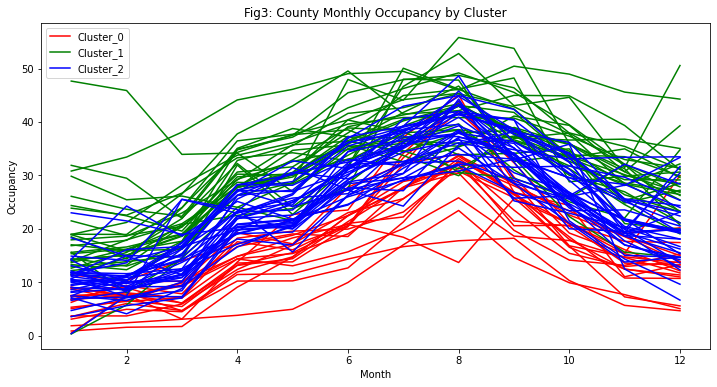

In [81]:
df_occ_month = df_occ_month.sort_values(by='month', ascending=True)
plt.figure(figsize=(12, 6))
for j in df_occ_month.cluster.unique():
    df_clu = df_occ_month[df_occ_month.cluster==j]
    cluster_colors = ['red', 'green', 'blue', 'orange'] 
    cluster_color = cluster_colors[j % len(cluster_colors)]
    for c in df_clu.county.unique():
        plt.plot(df_clu[df_clu.county==c].month, df_clu[df_clu.county==c].occupancy_monthly_mean, color=cluster_color)
for j in df_occ_month.cluster.unique():
    plt.plot([], [], color=cluster_colors[j % len(cluster_colors)], label=f'Cluster_{j}')
plt.xlabel('Month')
plt.ylabel('Occupancy')
plt.title('Fig3: County Monthly Occupancy by Cluster')
plt.legend()
plt.show()


# Comparing NSI and daily datas

In [82]:
df_comp = pd.merge(df_occ_month, df_nsi, on=['county','month'])

In [83]:
df_comp['occupancy_yearly_mean'] = df_comp.groupby('month').occupancy_monthly_mean.transform('mean')
df_comp['nsi_occupancy_yearly_mean'] = df_comp.groupby('month').nsi_occupancy_level.transform('mean')
df_comp['occ_diff'] = df_comp['occupancy_monthly_mean'] - df_comp['nsi_occupancy_level']
df_comp['occ_diff_abs'] = df_comp.occ_diff.abs()
df_comp['occ_diff_abs_mean'] = df_comp.groupby('month').occ_diff_abs.transform('mean')
df_comp['occ_diff_mean'] = df_comp.groupby('month').occ_diff.transform('mean')

No handles with labels found to put in legend.


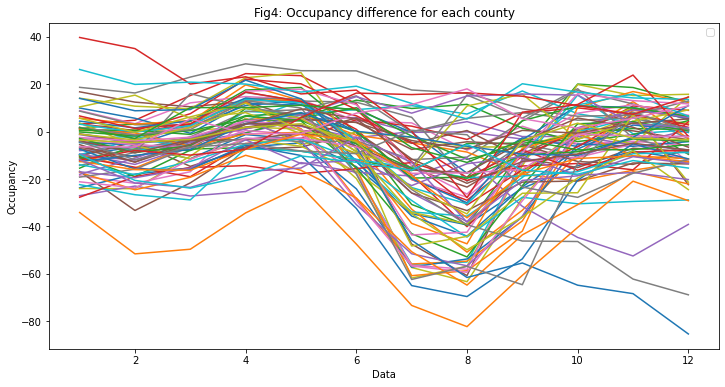

In [84]:
df_comp = df_comp.sort_values(by='month', ascending=True)
plt.figure(figsize=(12, 6))
for c in df_comp.county.unique().tolist():
    plt.plot(df_comp[df_comp.county==c].month, df_comp[df_comp.county==c].occ_diff)
plt.xlabel('Data')
plt.ylabel('Occupancy')
plt.title('Fig4: Occupancy difference for each county')
plt.legend()
plt.show()

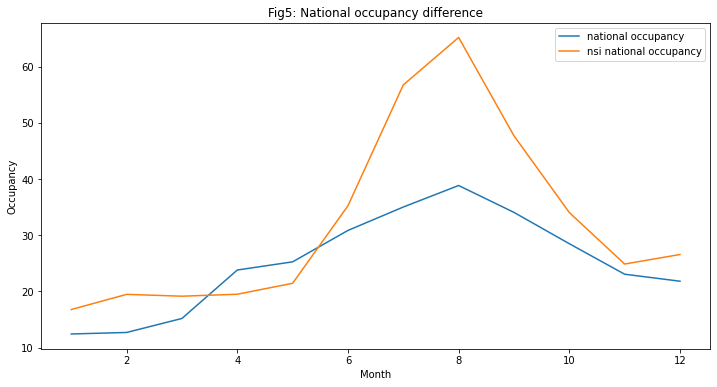

In [85]:
df_comp = df_comp.sort_values(by='month', ascending=True)
plt.figure(figsize=(12, 6))
plt.plot(df_comp.drop_duplicates(subset='month').month, df_comp.drop_duplicates(subset='month').occupancy_yearly_mean, label='national occupancy')
plt.plot(df_comp.drop_duplicates(subset='month').month, df_comp.drop_duplicates(subset='month').nsi_occupancy_yearly_mean, label='nsi national occupancy')
plt.xlabel('Month')
plt.ylabel('Occupancy')
plt.title('Fig5: National occupancy difference')
plt.legend()
plt.show()

# Analyze and visualize spatial patterns

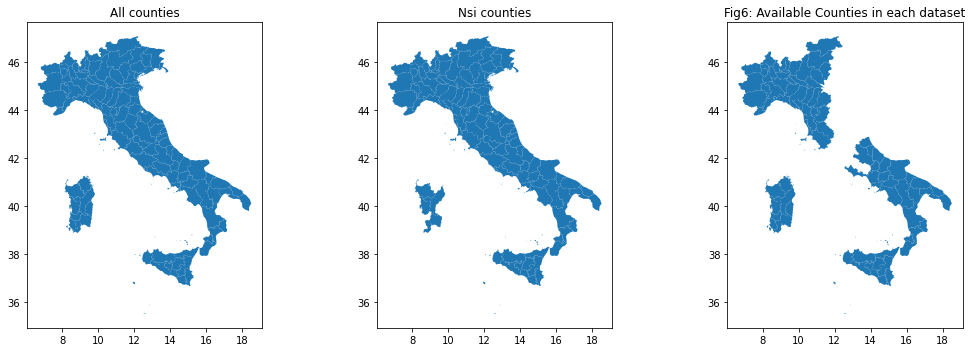

In [86]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

gdf.plot(ax=axs[0])
axs[0].set_title("All counties")
gdf[gdf.county.isin(df_nsi.county)].plot(ax=axs[1])
axs[1].set_title("Nsi counties")
gdf[gdf.county.isin(df_occ.county)].plot(ax=axs[2])
axs[2].set_title("Daily data counties")
plt.tight_layout()
plt.title('Fig6: Available Counties in each dataset')
plt.show()

In [87]:
gdf_occ = gdf[gdf.county.isin(df_occ.county)]
gdf_occ = gdf_occ.merge(df_occ_month.drop_duplicates(subset='county')[['county','cluster']], on='county')
gdf_occ = gdf_occ.merge(df_occ.drop_duplicates(subset='county')[['county','occupancy_yearly_mean']], on='county')

In [88]:
#Moran's I test to see if there is spatial correlations between couties
import geopandas as gpd
import libpysal
from esda.moran import Moran
import matplotlib.pyplot as plt

w = libpysal.weights.Queen.from_dataframe(gdf_occ)

spatial_lag = libpysal.weights.lag_spatial(w, gdf_occ['occupancy_yearly_mean'])

moran = Moran(gdf_occ['occupancy_yearly_mean'], w)

moran_i = moran.I
p_value = moran.p_sim

print(f"Moran's I = {moran_i:.4f}\np-value = {p_value:.4f}")

Moran's I = 0.3387
p-value = 0.0010


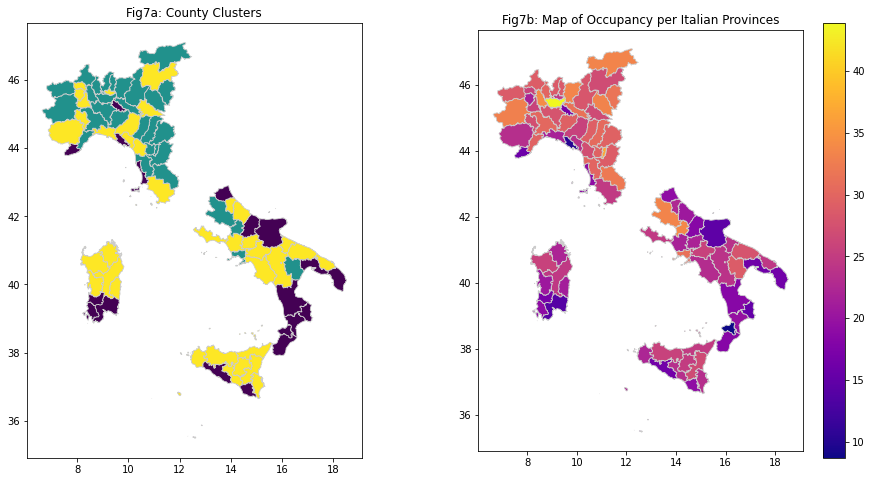

In [89]:
colormap1 = 'viridis'
colormap2 = 'plasma'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

gdf_occ.plot(column='cluster', cmap=colormap1, linewidth=0.8, ax=ax1, edgecolor='0.8', legend=False)
ax1.set_title('Fig7a: County Clusters')

gdf_occ.plot(column='occupancy_yearly_mean', cmap=colormap2, linewidth=0.8, ax=ax2, edgecolor='0.8', legend=True)
ax2.set_title('Fig7b: Map of Occupancy per Italian Provinces')

plt.show()

In [90]:
gdf_comp = gdf[gdf.county.isin(df_comp.county)]
gdf_comp = gdf_comp.merge(df_comp[['county','occ_diff','month']], on='county')

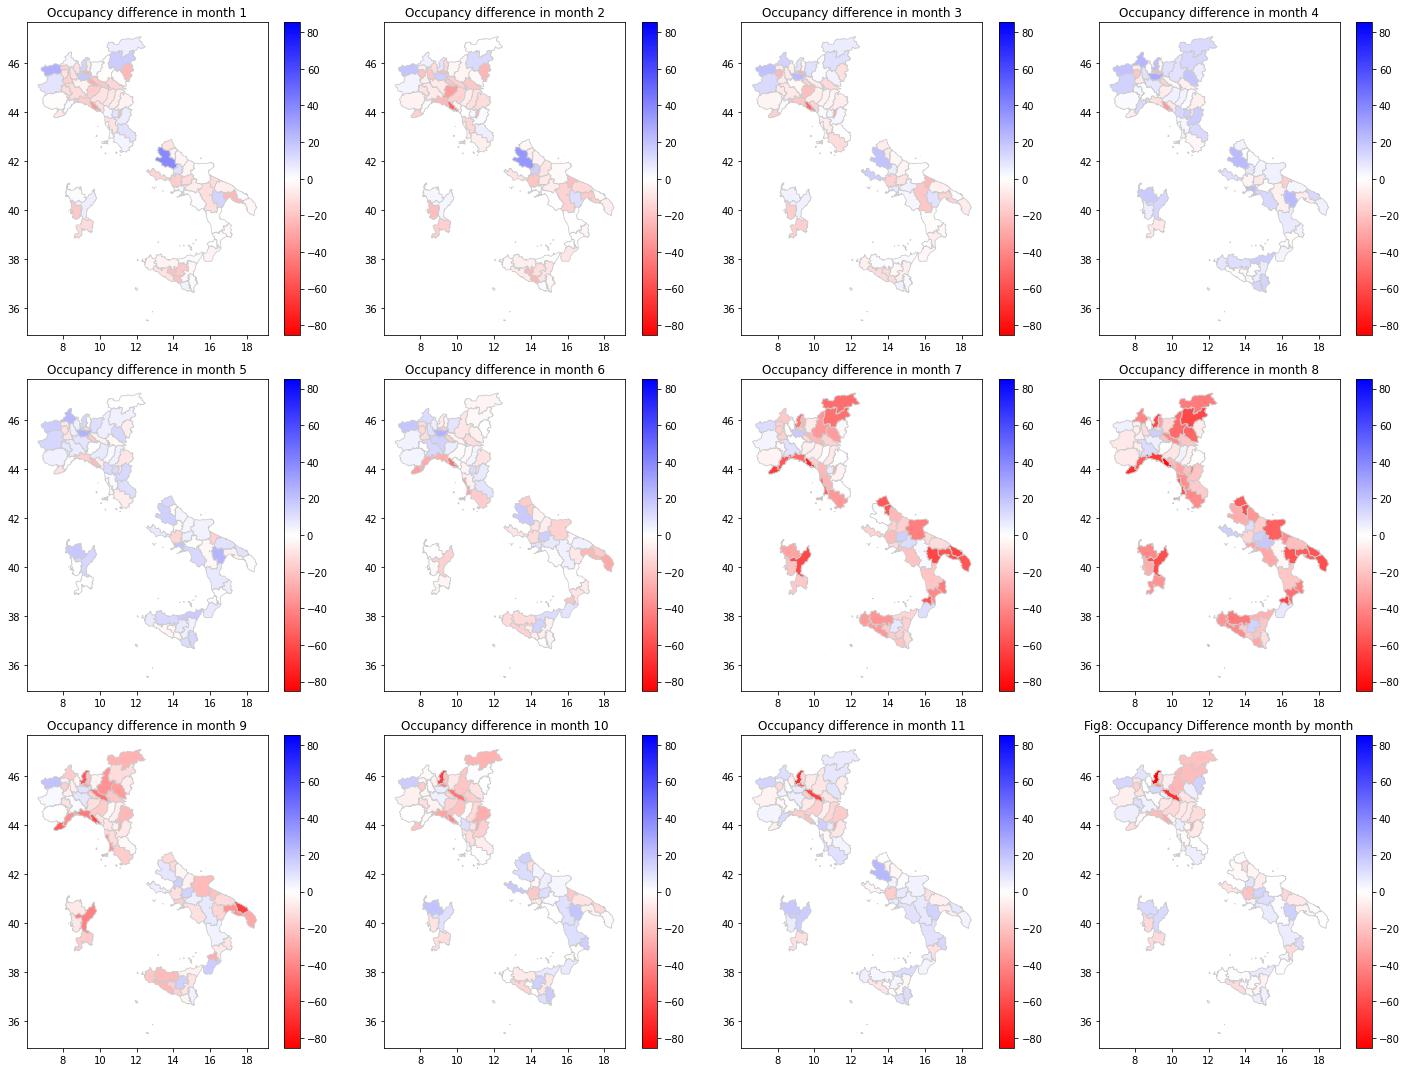

In [91]:
import matplotlib.pyplot as plt

global_min = gdf_comp['occ_diff'].min()
global_max = gdf_comp['occ_diff'].max()
abs_max = max(abs(global_min),abs(global_max))

colors = [(0, 'red'), (0.5, 'white'), (1, 'blue')] 

custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)

fig, axs = plt.subplots(3, 4, figsize=(20, 15))

axs = axs.flatten()

for i, month in enumerate(range(1, 13)):
    ax = axs[i]
    gdf_month = gdf_comp[gdf_comp['month'] == month]
    gdf_month.plot(column='occ_diff', cmap=custom_cmap, linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, vmin=-abs_max, vmax=abs_max)
    ax.set_title(f'Occupancy difference in month {month}')
plt.title('Fig8: Occupancy Difference month by month')
plt.tight_layout()
plt.show()


# Forecasting aggregating by cluster and by country

In [92]:
#We extract some features (exogenous variable) obtained from the date
df_occ['day_of_week'] = df_occ['date'].dt.dayofyear
df_occ['day_of_week'] = df_occ.day_of_week%7
df_occ['day_avg_occ'] = df_occ.groupby('day_of_week').occupancy_level.transform('mean')
df_occ['holiday'] = np.where(df_occ.date.isin(before_holidays), 1,0)

In [93]:
#Watching day_avg_week it's easy to notice that day_of_week=1 is saturday
df_occ.drop_duplicates(subset='day_of_week')

,date,county,occupancy_level,month,occupancy_monthly_mean,occupancy_yearly_mean,daily_national_occupancy,day_of_week,day_avg_occ,holiday
0,2022-01-01,agrigento,13.41,1,7.440645,16.440466,21.537560,1,32.792330,0
1831,2022-01-02,bari,9.81,1,11.309355,27.896740,10.812530,2,21.562169,0
13910,2022-01-03,lecco,16.13,1,14.426935,28.604726,10.395595,3,21.836197,0
20865,2022-01-04,parma,12.37,1,13.114032,25.627493,10.948333,4,24.010556,0
22330,2022-01-05,pisa,12.75,1,15.332258,29.941507,12.564405,5,24.573677,1
8057,2022-01-06,como,43.01,1,26.074839,28.721151,12.684643,6,23.973913,0
27273,2022-01-07,teramo,0.00,1,0.460161,19.169110,13.862024,0,25.753301,0


In [94]:
#Update with Saturdays the holiday days
df_occ['holiday'] = np.where(df_occ.day_of_week==1, 1, df_occ.holiday)

In [95]:
df_occ = df_occ.merge(df_occ_month[['county','cluster']], on='county', how='left')
df_occ['occupancy'] = df_occ.groupby(['date','cluster']).occupancy_level.transform('mean')
df_cluster = df_occ.drop_duplicates(subset=['date','cluster'])

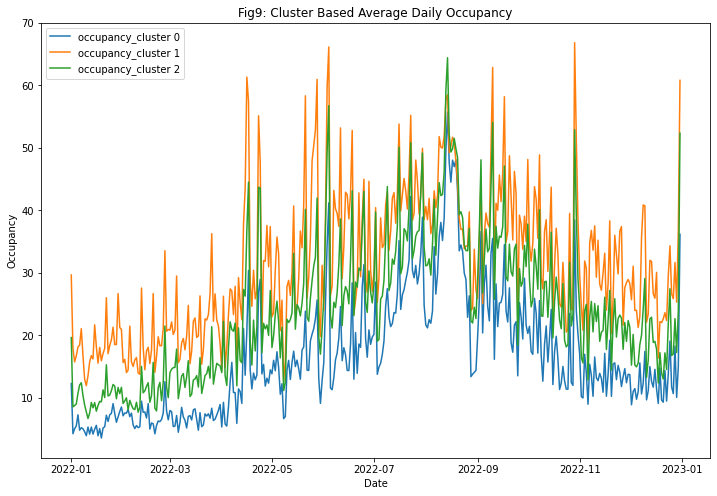

In [96]:
plt.figure(figsize=(12, 8))
for i in df_cluster.cluster.unique():
    plt.plot(df_cluster[df_cluster.cluster==i].date, df_cluster[df_cluster.cluster==i].occupancy, label = f'occupancy_cluster {i}')
plt.xlabel('Date')
plt.ylabel('Occupancy')
plt.title('Fig9: Cluster Based Average Daily Occupancy')
plt.legend()
plt.show()

In [97]:
df_occ['occupancy'] = df_occ.groupby('date')['occupancy_level'].transform('mean')
df_ita = df_occ.drop_duplicates(subset='date')

In [98]:
#Defining function to compute MAPE
def fun_mape(y_true,y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    errors = np.abs((y_true - y_pred)/y_true)*100
    mape = np.mean(errors)
    return mape

def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

def lstm_forecast(df, DATE, seq_length=7, epochs=50, batch_size=16):
    tf.random.set_seed(42)
    df.sort_values(by='date', inplace=True)
    df_train = df[df.date <= DATE]
    df_test = df[df.date > DATE]
    train_data = df_train['occupancy']
    test_data = df_test['occupancy']
    test_date = df_test['date']
    
    scaler = MinMaxScaler()
    train_data_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1))
    test_data_scaled = scaler.transform(test_data.values.reshape(-1, 1))
    
    X_train, y_train = create_sequences(train_data_scaled, seq_length)
    X_test, y_test = create_sequences(test_data_scaled, seq_length)
        
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    mape = fun_mape(y_test, y_pred)
    print('MAPE: ',mape)
    return y_pred.flatten(), mape

In [99]:
DATE = pd.to_datetime("2022-10-31")

y_pred, mape = lstm_forecast(df_ita, DATE)
y_pred0, mape1 = lstm_forecast(df_cluster[df_cluster.cluster==0],DATE)
y_pred1, mape2 = lstm_forecast(df_cluster[df_cluster.cluster==1], DATE)
y_pred2, mape1 = lstm_forecast(df_cluster[df_cluster.cluster==2],DATE)

2/2 [==============================] - 0s 5ms/step
MAPE:  20.765815684967546
2/2 [==============================] - 0s 3ms/step
MAPE:  23.317010432809894
2/2 [==============================] - 0s 3ms/step
MAPE:  20.219793523083787
2/2 [==============================] - 0s 3ms/step
MAPE:  21.42377648821012


In [100]:
def create_sequences_ex(data, exog, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(np.column_stack((data[i:i+seq_length, 0], exog[i:i+seq_length, :])))
        y.append(data[i+seq_length, 0])
    return np.array(X), np.array(y)

def lstm_forecast_ex(df, exog_var_name, DATE, seq_length=7, epochs=50, batch_size=16):
    tf.random.set_seed(42)
    df.sort_values(by='date', inplace=True)
    df_train = df[df.date <= DATE]
    df_test = df[df.date > DATE]
    train_data = df_train['occupancy']
    test_data = df_test['occupancy']
    test_date = df_test['date']

    # Extract exogenous variables
    train_exog = df_train[exog_var_name]
    test_exog = df_test[exog_var_name]

    scaler_target = MinMaxScaler()
    scaler_exog = MinMaxScaler()

    train_data_scaled = scaler_target.fit_transform(train_data.values.reshape(-1, 1))
    train_exog_scaled = scaler_exog.fit_transform(train_exog)

    test_data_scaled = scaler_target.transform(test_data.values.reshape(-1, 1))
    test_exog_scaled = scaler_exog.transform(test_exog)

    X_train, y_train = create_sequences_ex(train_data_scaled, train_exog_scaled, seq_length)
    X_test, y_test = create_sequences_ex(test_data_scaled, test_exog_scaled, seq_length)

    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(seq_length, X_train.shape[2]), return_sequences=True))
    model.add(LSTM(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    y_pred = model.predict(X_test)
    y_pred = scaler_target.inverse_transform(y_pred)
    y_test = scaler_target.inverse_transform(y_test.reshape(-1, 1))

    mape = fun_mape(y_test, y_pred)
    print('MAPE: ',mape)
    return y_pred.flatten(), mape, 

In [101]:
DATE = pd.to_datetime("2022-10-31")
exog_var_name = ['day_of_week','holiday']

y_pred, mape = lstm_forecast_ex(df_ita, exog_var_name, DATE, seq_length=7, epochs=50, batch_size=16)
y_pred0, mape1 = lstm_forecast_ex(df_cluster[df_cluster.cluster==0],exog_var_name, DATE, seq_length=7, epochs=50, batch_size=16)
y_pred1, mape2 = lstm_forecast_ex(df_cluster[df_cluster.cluster==1],exog_var_name, DATE, seq_length=7, epochs=50, batch_size=16)
y_pred2, mape1 = lstm_forecast_ex(df_cluster[df_cluster.cluster==2],exog_var_name, DATE, seq_length=7, epochs=50, batch_size=16)

2/2 [==============================] - 0s 4ms/step
MAPE:  15.99762957340558
2/2 [==============================] - 0s 7ms/step
MAPE:  24.327732822281664
2/2 [==============================] - 0s 4ms/step
MAPE:  14.76123506218721
2/2 [==============================] - 0s 4ms/step
MAPE:  18.27043437551666


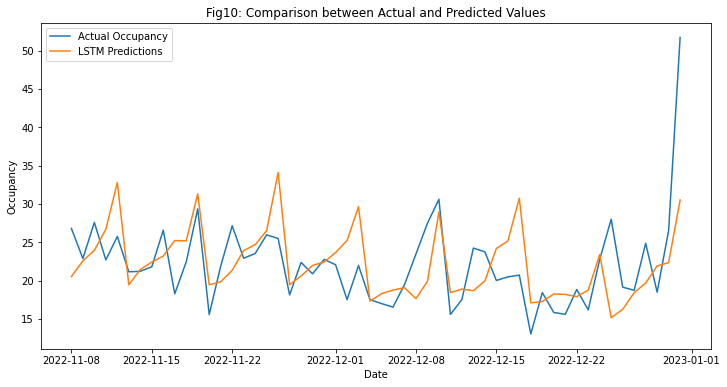

In [102]:
plt.figure(figsize=(12, 6))
plt.plot(df_ita[df_ita.date > DATE]['date'][7:], df_ita[df_ita.date > DATE]['occupancy'][7:], label='Actual Occupancy')
plt.plot(df_ita[df_ita.date > DATE]['date'][7:], y_pred, label='LSTM Predictions')
plt.xlabel('Date')
plt.ylabel('Occupancy')
plt.title('Fig10: Comparison between Actual and Predicted Values')
plt.legend()
plt.show()